# Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pickle
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from collections import defaultdict, Counter

# Pre-Processing

In [2]:
df = pd.read_csv("./kieranFeatures_1-30_14-Nov-2024_rawSA.csv").replace([np.inf, -np.inf], np.nan).interpolate() # Perform linear interpolation on all non-valid numbers

df["Lv_1_Hi"] = (df["SA1"] >= 5).astype(int)
df["Lv_2_Hi"] = (df["SA2"] >= 5).astype(int)
df["Lv_3_Hi"] = (df["SA3"] >= 5).astype(int)
df["Tot_Hi"] = (df["SAtotal"] >= 15).astype(int)

ids = df.iloc[:, 0]
trial_nums = df.iloc[:, 1]
predictors_df = df.iloc[:, 2:df.shape[1] - 8]
outcomes_df = df.iloc[:, df.shape[1] - 8:]

# Free Memory
del df

## Checking Distribution of Binary Outcome Vars

In [55]:
def get_binomial_distribution(x, split_1, split_2):
    split_1_data = (df[x] >= split_1).astype(int)
    split_2_data = (df[x] >= split_2).astype(int)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle("Distribution of High " + x)
    fig.set_figwidth(10)

    # Split 1 Subplot (Left)
    data_1 = Counter(split_1_data)

    ax1.bar([0, 1], [data_1[0], data_1[1]])
    
    ax1.set_xticks([0, 1])

    ax1.set_ylim([0, 250])

    ax1.set_xlabel("High " + x)
    ax1.set_ylabel("Count")
    ax1.set_title("Split at >= " + str(split_1))



    # Split 2 Subplot (Right)
    data_2 = Counter(split_2_data)

    ax2.bar([0, 1], [data_2[0], data_2[1]])
    
    ax2.set_xticks([0, 1])

    ax2.set_ylim([0, 250])

    ax2.set_xlabel("High " + x)
    ax2.set_ylabel("Count")


    ax2.set_title("Split at >= " + str(split_2))

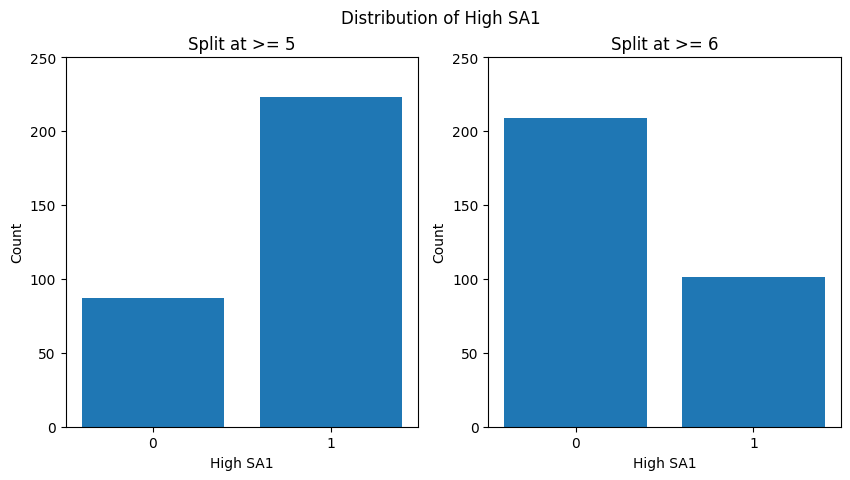

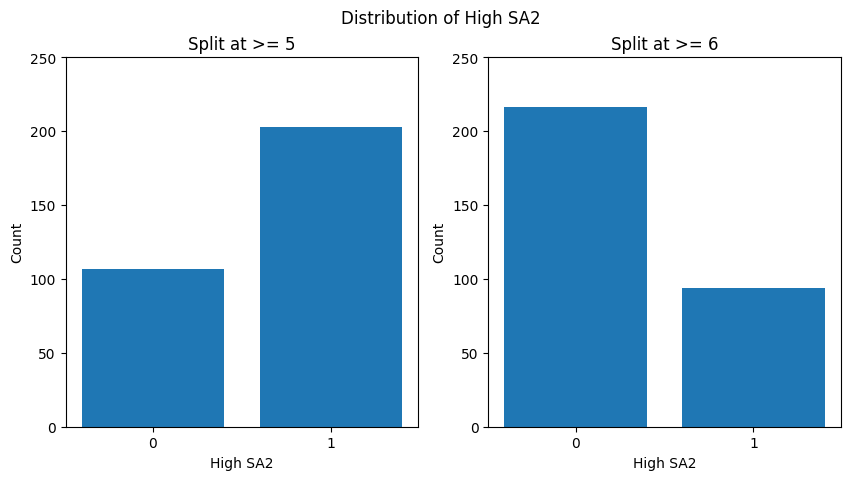

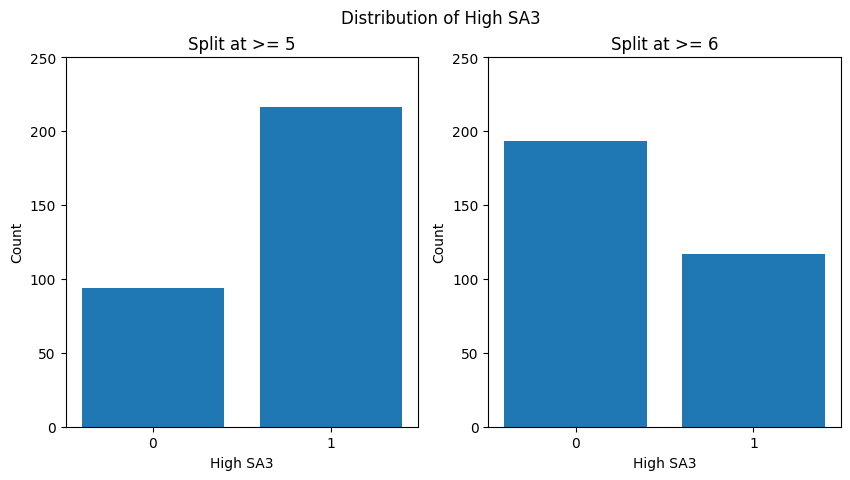

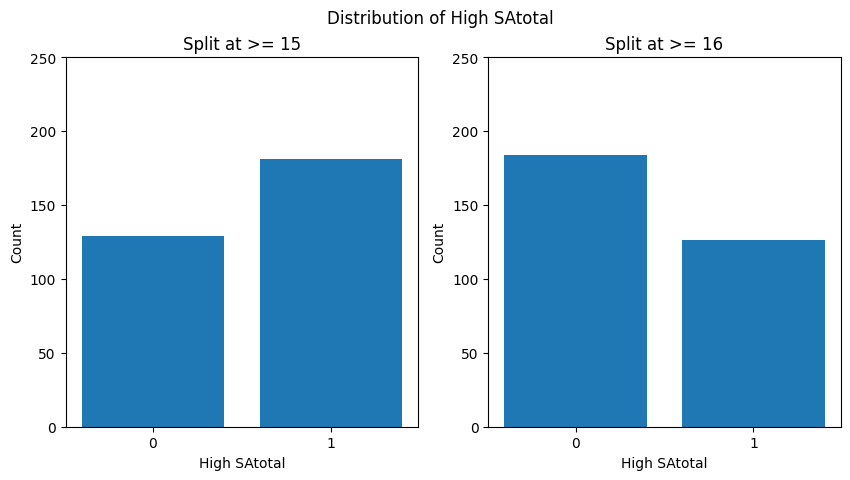

In [ ]:
get_binomial_distribution("SA1", 5, 6)
get_binomial_distribution("SA2", 5, 6)
get_binomial_distribution("SA3", 5, 6)
get_binomial_distribution("SAtotal", 15, 16)

# Cross Validation

In [ ]:
# About 40 mins
outcome_var = "Lv_1_Hi"

models = {
    "No Penalty": [],
    "LASSO": []
}

f1_scores = {
    "No Penalty": [],
    "LASSO": []
}

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for i, (CV_idx, test_idx) in enumerate(skf.split(predictors_df, outcomes_df[outcome_var])):
    # Train-Test Split for the Fold
    ids_CV = ids.iloc[CV_idx]
    ids_test = ids.iloc[test_idx]
    trial_nums_CV = ids.iloc[CV_idx]
    trial_nums_test = ids.iloc[test_idx]
    pred_CV = predictors_df.iloc[CV_idx, :]
    pred_test = predictors_df.iloc[test_idx, :]
    out_CV = outcomes_df.iloc[CV_idx, :]
    out_test = outcomes_df.iloc[test_idx, :]

    # Setup Cross Validation Object
    rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)
    
    # Initialize Models to Train
    no_penalty_model = LogisticRegression(
        fit_intercept = False,
        solver = "saga",
        n_jobs = -1,
        max_iter = 20000,
        class_weight = "balanced",
        penalty = None
    )

    LASSO_model = LogisticRegressionCV(
        Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
        cv = rskf.split(pred_CV, ids_CV), 
        fit_intercept = False, 
        penalty = "l1", 
        solver = "saga", 
        n_jobs = -1, 
        max_iter = 20000, 
        scoring = "f1_score", 
        refit = True
    )

    relaxed_LASSO_model = LogisticRegression(
        fit_intercept = False,
        solver = "saga",
        n_jobs = -1,
        max_iter = 20000,
        class_weight = "balanced",
    )

    # Fit Models
    no_penalty_model.fit(pred_CV, out_CV[outcome_var])
    LASSO_model.fit(pred_CV, out_CV[outcome_var])

    # Obtain "Relaxed LASSO" Model
    selector = SelectFromModel(LASSO_model, prefit = True)
    pred_CV_selected = selector.transform(pred_CV)
    pred_test_selected = selector.transform(pred_test)
    relaxed_LASSO_model.fit(pred_CV_selected, out_CV[outcome_var])

    # Add Models and Scores to Dictionaries
    models["No Penalty"].append(no_penalty_model)
    models["LASSO"].append(LASSO_model)